## Setup

In [321]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [322]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [323]:
# import libraries
import os

## Using pretrained model

In [324]:
fast_sam_checkpoint = "./FastSAM-x.pt"
fast_sam_s_checkpoint = "./FastSAM-s.pt"

In [325]:
# prompt: device = "cuda" or cpu

device = "cpu"

In [326]:
from fastsam import FastSAM, FastSAMPrompt

model_fast_sam = FastSAM(fast_sam_checkpoint)
model_fast_sam_s = FastSAM(fast_sam_s_checkpoint)

In [327]:
dataset_path = "./box_train/train/"

## Example image

In [328]:
def list_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more if needed
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files

image_paths = list_image_files(dataset_path)

In [329]:
image_paths[:5]

['./box_train/train/box_0.jpg',
 './box_train/train/box_1.jpg',
 './box_train/train/box_100.jpg',
 './box_train/train/box_101.jpg',
 './box_train/train/box_102.jpg']

In [330]:
img_index = 30

In [331]:
sample_img_path = image_paths[img_index]

In [332]:
print(sample_img_path)

./box_train/train/box_17.jpg


In [333]:
image = cv2.imread(sample_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

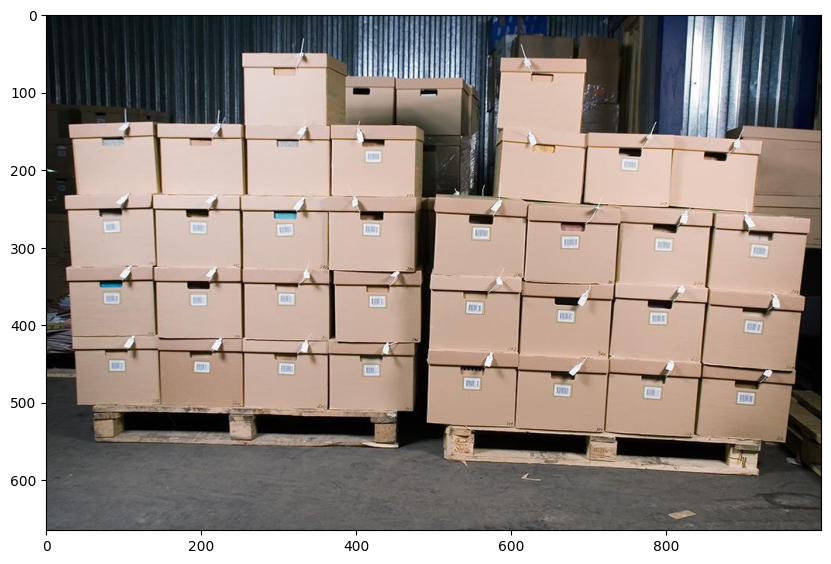

In [334]:
def plot_image(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  plt.axis('on')
  plt.show()

plot_image(image)

In [335]:
# prompt: get image resolution

image_height, image_width, _ = image.shape
print(f"Image resolution: {image_width}x{image_height}")


Image resolution: 1000x665


In [336]:
center_point_coords = [ int(image_width/2), int(image_height/2)]
center_point_coords

[500, 332]

In [337]:
input_point = np.array([center_point_coords])
input_label = np.array([1])
input_point, input_label

(array([[500, 332]]), array([1]))

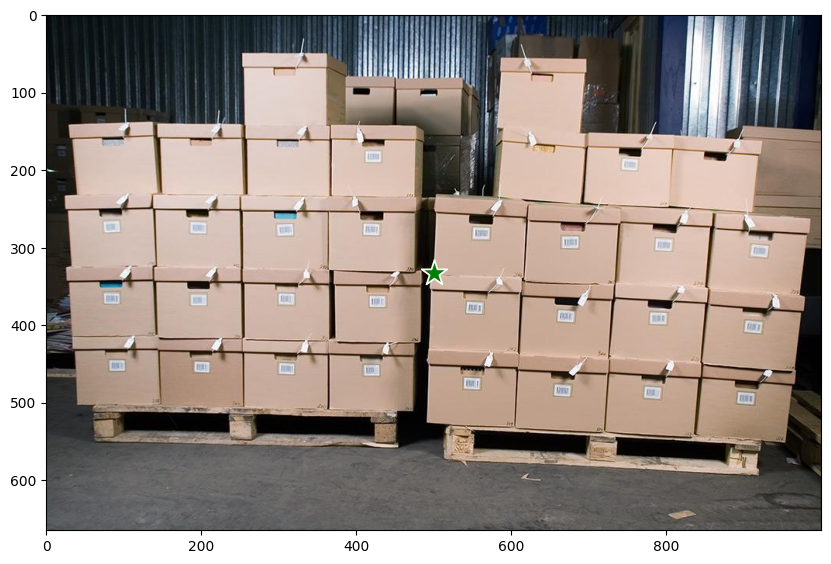

In [338]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

### Mask prediction

In [339]:
fast_sam_predictor = model_fast_sam(image, device=device, retina_masks=True, imgsz=930, conf=0.4, iou=0.9,)
fast_sam_prompt_process = FastSAMPrompt(image, fast_sam_predictor, device=device)


WARNING  imgsz=[930] must be multiple of max stride 32, updating to [960]
0: 640x960 136 objects, 12226.6ms
Speed: 31.0ms preprocess, 12226.6ms inference, 2746.5ms postprocess per image at shape (1, 3, 640, 960)


In [340]:
# everything prompt
# mask = fast_sam_prompt_process.everything_prompt()

In [341]:
# bbox default shape [0,0,0,0] -> [x1,y1,x2,y2]
# ann = fast_sam_prompt_process.box_prompt(bboxes=[[200, 200, 300, 300]])

In [342]:
# text prompt
# ann = fast_sam_prompt_process.text_prompt(text='a photo of a box')

In [343]:
# point prompt
# points default [[0,0]] [[x1,y1],[x2,y2]]
# point_label default [0] [1,0] 0:background, 1:foreground
mask = fast_sam_prompt_process.point_prompt(points=[center_point_coords], pointlabel=[1])
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [344]:
mask.shape # (channels, height, width)

(1, 665, 1000)

In [345]:
annotated_file_output_path = "./box_annotated_sample_img.jpg"

In [346]:
def plot_mask_with_score(image, title,mask, input_point, input_label ):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {title}", fontsize=18)
    plt.axis('on')
    plt.show()

In [347]:
input_point = np.array([center_point_coords])
input_label = np.array([1])

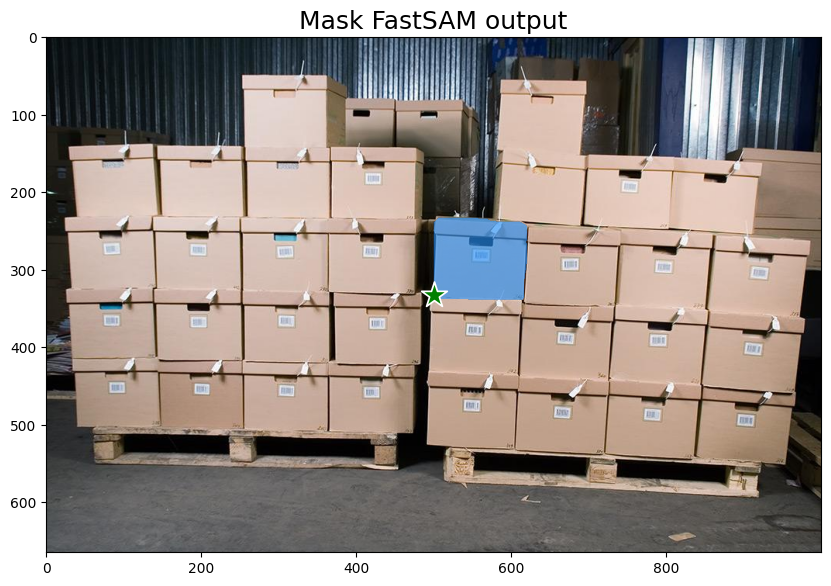

In [348]:
plot_mask_with_score(image, "FastSAM output", mask, input_point, input_label )

In [349]:
sample_mask = mask
sample_mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [350]:
sample_mask.shape

(1, 665, 1000)

In [351]:
image.shape

(665, 1000, 3)

**Both image and mask should be in format of (height, width, channels)**

The mask and the image are not in the correct matching dimensions. We have to map this one.


In [352]:
reshaped_mask = np.transpose(sample_mask, (1, 2, 0))
reshaped_mask.shape

(665, 1000, 1)

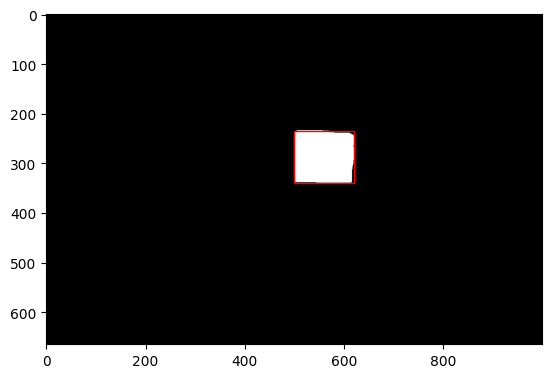

In [353]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_square(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the mask
    ax.imshow(mask, cmap='gray')

    # Create a rectangle patch
    rect = patches.Rectangle((top_left[1], top_left[0]), width, height, linewidth=1, edgecolor='r', facecolor='none')

    
    # Add the rectangle patch to the axis
    ax.add_patch(rect)

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have your mask array named "mask"
plot_square(reshaped_mask)


### get_bounding_box_coordinates()  function breakdown

In [354]:
# # Find the indices where the mask is True
#     true_indices = np.argwhere(mask)

#     # Get the bounding box of the True region
#     top_left = np.min(true_indices, axis=0)
#     bottom_right = np.max(true_indices, axis=0)

#     # Calculate the width and height of the bounding box
#     width = bottom_right[1] - top_left[1]
#     height = bottom_right[0] - top_left[0]

#     # Create a figure and axis
#     fig, ax = plt.subplots(1)

#     # Plot the mask
#     ax.imshow(mask, cmap='gray')

#     # Create a rectangle patch
#     rect = patches.Rectangle((top_left[1], top_left[0]), width, height, linewidth=1, edgecolor='r', facecolor='none')

#     # Add the rectangle patch to the axis
#     ax.add_patch(rect)

#     # Show the plot
#     plt.show()

In [355]:
reshaped_mask.shape

(665, 1000, 1)

In [356]:
true_indices = np.argwhere(reshaped_mask)
print(f"{true_indices.shape=}")
print(f"{true_indices=}")

true_indices.shape=(12331, 3)
true_indices=array([[234, 506,   0],
       [234, 507,   0],
       [234, 508,   0],
       ...,
       [339, 613,   0],
       [339, 614,   0],
       [339, 615,   0]], dtype=int64)


In [357]:
# Get the bounding box of the True region
top_left = np.min(true_indices, axis=0)
bottom_right = np.max(true_indices, axis=0)

# Remove the channels layer coordinate 
top_left = top_left[:-1]
bottom_right = bottom_right[:-1]

print(f"{top_left=}")
print(f"{bottom_right=}")

top_left=array([234, 500], dtype=int64)
bottom_right=array([339, 620], dtype=int64)


In [358]:
# Calculate the width and height of the bounding box
width = bottom_right[1] - top_left[1]
height = bottom_right[0] - top_left[0]
    
print(f"{width=}")
print(f"{height=}")

width=120
height=105


In [359]:
# make a numpy array for top_right and bottom_left
top_right = np.array([top_left[1] + width , top_left[0]])
bottom_left = np.array([top_left[1], top_left[0] + height])

print(f"{top_right=}")
print(f"{bottom_left=}")

top_right=array([620, 234], dtype=int64)
bottom_left=array([500, 339], dtype=int64)


In [360]:
print(f"{top_left=}")
print(f"{bottom_right=}")
print(f"{top_right=}")
print(f"{bottom_left=}")

top_left=array([234, 500], dtype=int64)
bottom_right=array([339, 620], dtype=int64)
top_right=array([620, 234], dtype=int64)
bottom_left=array([500, 339], dtype=int64)


In [361]:
# updated code 
def get_bounding_box_coordinates(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = tuple(np.min(true_indices, axis=0))
    bottom_right = tuple(np.max(true_indices, axis=0))

    # Remove the channels layer coordinate 
    top_left = top_left[:-1]
    bottom_right = bottom_right[:-1]

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # make a numpy array for top_right and bottom_left
    top_right = ( top_left[0], top_left[1] + width)
    bottom_left = (top_left[0] + height, top_left[1] )

    return {"top_left":top_left, "top_right":top_right, "bottom_right":bottom_right, "bottom_left":bottom_left}

In [362]:
get_bounding_box_coordinates(reshaped_mask)


{'top_left': (234, 500),
 'top_right': (234, 620),
 'bottom_right': (339, 620),
 'bottom_left': (339, 500)}

In [363]:
get_bounding_box_coordinates(reshaped_mask)

{'top_left': (234, 500),
 'top_right': (234, 620),
 'bottom_right': (339, 620),
 'bottom_left': (339, 500)}

## Pipeline

In [364]:

def get_box_coordinates(img, model, device,  showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=True):
  """
  Returns : a dictionary containing the coordinates of the bounding box
            in the format {"top_left":top_left, "top_right":top_right, "bottom_right":bottom_right, "bottom_left":bottom_left}
            in (y, x) format
  """

  # plot original image
  if showOriginalImage:
    plot_image(img)

  # get image dimensions
  img_height, img_width, _ = img.shape

  # get centre point coordinates
  center_point_coords = [ int(img_width/2), int(img_height/2)]
  input_point = np.array([center_point_coords])
  input_label = np.array([1])

  if showPoints:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()


  # draw a rectangle that makes the center point of image

  # generate the mask in the relevant area
  
    
  fast_sam_predictor = model(img, device=device, retina_masks=True, imgsz=img_width, conf=0.4, iou=0.9,)
  fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)

  # point prompt
  # points default [[0,0]] [[x1,y1],[x2,y2]]
  # point_label default [0] [1,0] 0:background, 1:foreground
  img_mask = fast_sam_prompt_process.point_prompt(points=input_point, pointlabel=input_label)


  # plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )

  # reshape image mask
  # print(img_mask.shape)
  img_mask = np.transpose(img_mask, (1, 2, 0))
  # print(img_mask.shape)

  if showPlotMaskWithHighestScore:
    plot_square(img_mask)

  # get the rectangular boxes
  bounding_box_coords_dict = get_bounding_box_coordinates(img_mask)

  # get the coordinates of the rectangular bounding box
  return bounding_box_coords_dict

In [365]:

def get_image_with_box_corners(frame, points_dict):
  """
  parameters
  ----------
  frame : np.array : image frame
  points_dict : dict : dictionary containing the coordinates of the corners of the bounding box
                       dictionary keys : "top_left", "top_right", "bottom_right", "bottom_left"
                       dictionary elements : tuple : (y, x) coordinates of the corners 
                       
  returns
  -------
  frame : np.array : image frame with the corners of the bounding box annotated
  """
  circle_radius = 5
  # Define colors for each point in RGB format (not BGR format)
  colors_dict = {"blue":(0, 0, 255),
                  "red": (255, 0, 0),
                  "green":(0, 255, 0),
                  "yellow":(255, 255, 0)}

  # Draw points on the original image
  
  #### Point should be in (x, y) format
  # top_left : red 
  cv2.circle(frame, (points_dict["top_left"][1], points_dict["top_left"][0]),circle_radius, colors_dict["red"], -1) 
  
  # top_right : blue
  cv2.circle(frame, (points_dict["top_right"][1], points_dict["top_right"][0]) ,circle_radius, colors_dict["blue"], -1)
  
  # bottom_right : green
  cv2.circle(frame, (points_dict["bottom_right"][1], points_dict["bottom_left"][0]),circle_radius, colors_dict["green"], -1)
  
  # bottom_left : yellow
  cv2.circle(frame, (points_dict["bottom_left"][1], points_dict["bottom_left"][0]),circle_radius, colors_dict["yellow"], -1)
  
  return frame
  


In [366]:
box_corners_coords = get_box_coordinates(image, model_fast_sam, device, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=False)
box_corners_coords


WARNING  imgsz=[1000] must be multiple of max stride 32, updating to [1024]
0: 704x1024 151 objects, 13894.2ms
Speed: 84.6ms preprocess, 13894.2ms inference, 3701.4ms postprocess per image at shape (1, 3, 704, 1024)


{'top_left': (234, 500),
 'top_right': (234, 620),
 'bottom_right': (339, 620),
 'bottom_left': (339, 500)}

In [367]:
annotated_img = get_image_with_box_corners(image, box_corners_coords)
annotated_img

array([[[ 9, 13, 16],
        [ 6, 10, 13],
        [ 6, 10, 13],
        ...,
        [ 1,  8, 18],
        [ 0,  7, 17],
        [ 0,  7, 15]],

       [[ 9, 13, 16],
        [ 6, 10, 13],
        [ 6, 10, 13],
        ...,
        [ 1,  8, 18],
        [ 0,  7, 17],
        [ 0,  7, 15]],

       [[10, 14, 17],
        [ 7, 11, 14],
        [ 6, 10, 13],
        ...,
        [ 1,  8, 18],
        [ 0,  7, 17],
        [ 0,  7, 15]],

       ...,

       [[91, 95, 98],
        [91, 95, 98],
        [91, 95, 98],
        ...,
        [69, 69, 67],
        [73, 73, 71],
        [77, 77, 75]],

       [[88, 92, 95],
        [88, 92, 95],
        [88, 92, 95],
        ...,
        [65, 65, 63],
        [72, 72, 70],
        [77, 77, 75]],

       [[86, 90, 93],
        [87, 91, 94],
        [86, 90, 93],
        ...,
        [65, 65, 63],
        [68, 68, 66],
        [73, 73, 71]]], dtype=uint8)

In [368]:
box_corners_coords

{'top_left': (234, 500),
 'top_right': (234, 620),
 'bottom_right': (339, 620),
 'bottom_left': (339, 500)}

In [369]:
tuple(box_corners_coords["top_left"])

(234, 500)

In [370]:
type(annotated_img)

numpy.ndarray

In [371]:
annotated_img.shape

(665, 1000, 3)

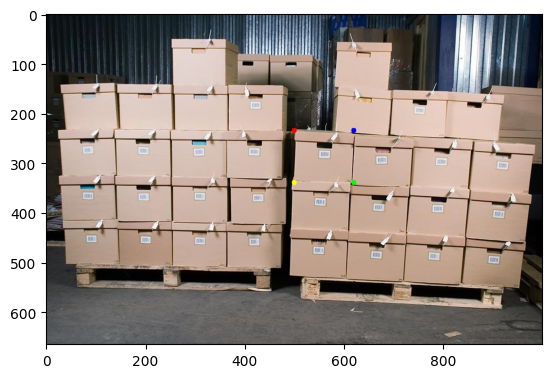

In [372]:
# plot annotated_img 
plt.imshow(annotated_img)

In [373]:
file_dir = "box_train/train/"
file_names = os.listdir("box_train/train") 

In [374]:
file_paths = [file_dir + file_name for file_name in file_names]
file_paths 

['box_train/train/box_0.jpg',
 'box_train/train/box_1.jpg',
 'box_train/train/box_100.jpg',
 'box_train/train/box_101.jpg',
 'box_train/train/box_102.jpg',
 'box_train/train/box_103.jpg',
 'box_train/train/box_104.jpg',
 'box_train/train/box_105.jpg',
 'box_train/train/box_106.jpg',
 'box_train/train/box_107.jpg',
 'box_train/train/box_108.jpg',
 'box_train/train/box_109.jpg',
 'box_train/train/box_11.jpg',
 'box_train/train/box_110.jpg',
 'box_train/train/box_111.jpg',
 'box_train/train/box_112.jpg',
 'box_train/train/box_113.jpg',
 'box_train/train/box_114.jpg',
 'box_train/train/box_115.jpg',
 'box_train/train/box_116.jpg',
 'box_train/train/box_117.jpg',
 'box_train/train/box_118.jpg',
 'box_train/train/box_119.jpg',
 'box_train/train/box_120.jpg',
 'box_train/train/box_121.jpg',
 'box_train/train/box_122.jpg',
 'box_train/train/box_123.jpg',
 'box_train/train/box_13.jpg',
 'box_train/train/box_15.jpg',
 'box_train/train/box_16.jpg',
 'box_train/train/box_17.jpg',
 'box_train/train